In [49]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
%matplotlib inline

In [11]:
%pip install seaborn plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\lzyda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
train_transaction = pd.read_csv('./data/raw/train_transaction.csv')
train_identity = pd.read_csv('./data/raw/train_identity.csv')
test_transaction = pd.read_csv('./data/raw/test_transaction.csv')
test_identity = pd.read_csv('./data/raw/test_identity.csv')

In [13]:
train_transaction = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)

In [14]:
test_transaction = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [15]:
print(train_transaction["TransactionDT"])
print(train_transaction["M2"])

0            86400
1            86401
2            86469
3            86499
4            86506
            ...   
590535    15811047
590536    15811049
590537    15811079
590538    15811088
590539    15811131
Name: TransactionDT, Length: 590540, dtype: int64
0           T
1         NaN
2           T
3         NaN
4         NaN
         ... 
590535      T
590536      F
590537      F
590538      T
590539      F
Name: M2, Length: 590540, dtype: object


In [16]:
print(train_identity.head())

   TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                  

In [ ]:
import seaborn as sns

In [ ]:
print(train_transaction.columns)

<AxesSubplot: >

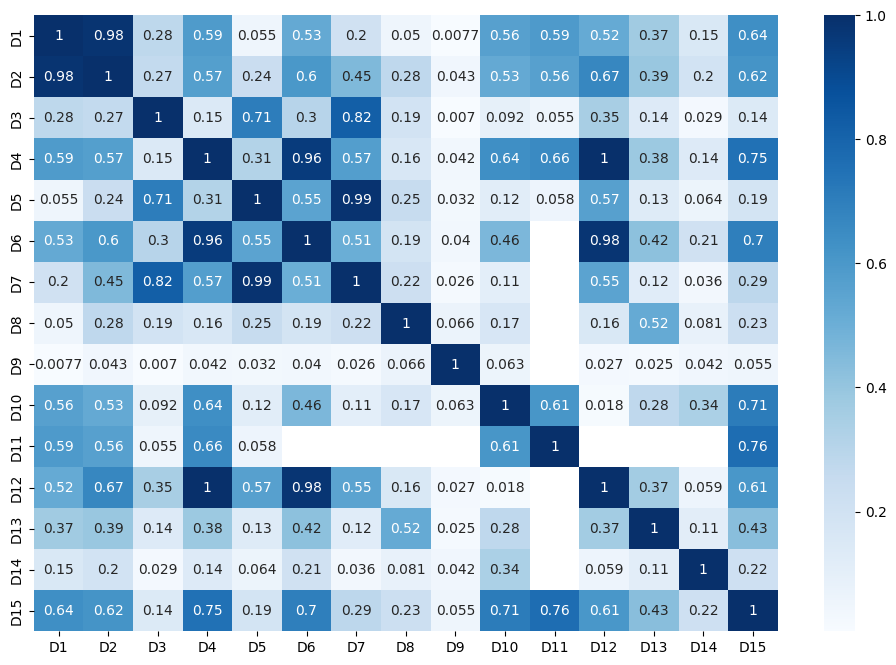

In [33]:
corr = train_transaction.loc[:, "D1":"D15"].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Blues", annot=True)

In [34]:
train_transaction['D1n'] =  train_transaction['D1'] -   train_transaction.TransactionDT/np.float32(24*60*60)

In [35]:
train_transaction['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [36]:
#Can remove columns with 90% missing values

def top_missing_cols(df,n=10,thresh=90):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [37]:
top_missing_cols(train_transaction, thresh=90)

There are 416 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


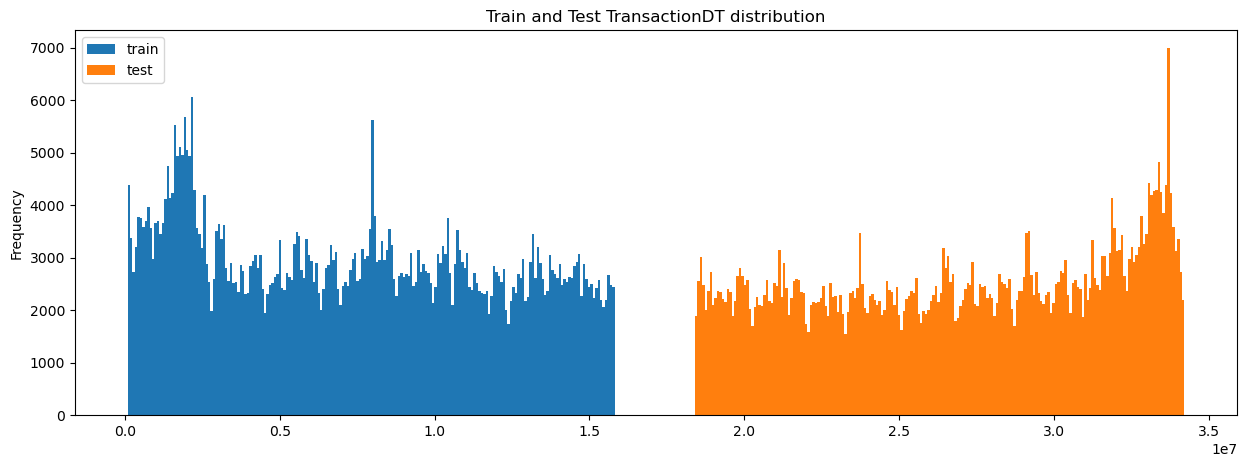

In [38]:
train_transaction['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist', label='test', bins=200)
plt.legend()
plt.show()

<Axes: title={'center': 'Train TransactionAmt distribution'}, ylabel='Frequency'>

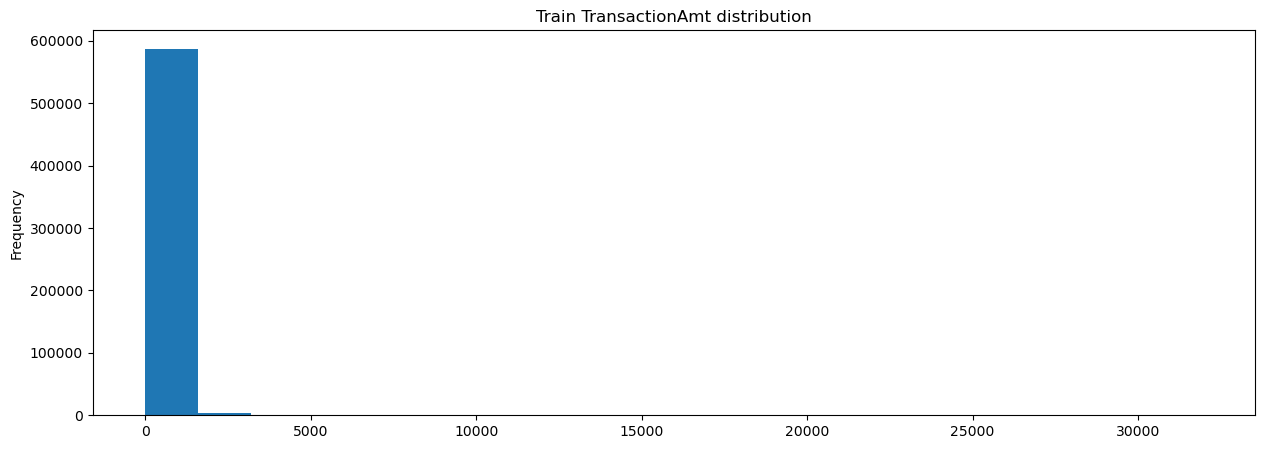

In [39]:
train_transaction['TransactionAmt'].plot(kind='hist', figsize=(15, 5), label='train', bins=20, title='Train TransactionAmt distribution')

<Axes: title={'center': 'Test TransactionAmt distribution'}, ylabel='Frequency'>

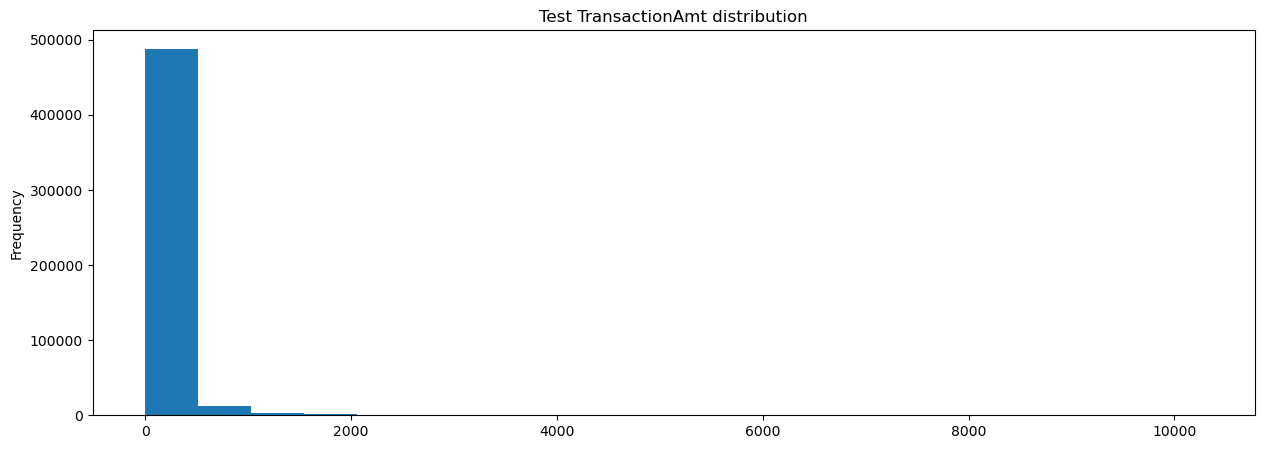

In [40]:
test_transaction['TransactionAmt'].plot(kind='hist', figsize=(15, 5), label='test', bins=20, title='Test TransactionAmt distribution')

In [42]:
def high_correlation(df, col_start, col_end, threshold):
    corr = df.loc[:, col_start:col_end].corr()
    print(corr[corr>0.9])
    # if > threshold: suggest remove
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if

high_correlation(train_transaction, "D1", "D15", 0.9)

           D1        D2   D3        D4        D5        D6        D7   D8  \
D1   1.000000  0.981311  NaN       NaN       NaN       NaN       NaN  NaN   
D2   0.981311  1.000000  NaN       NaN       NaN       NaN       NaN  NaN   
D3        NaN       NaN  1.0       NaN       NaN       NaN       NaN  NaN   
D4        NaN       NaN  NaN  1.000000       NaN  0.956966       NaN  NaN   
D5        NaN       NaN  NaN       NaN  1.000000       NaN  0.986496  NaN   
D6        NaN       NaN  NaN  0.956966       NaN  1.000000       NaN  NaN   
D7        NaN       NaN  NaN       NaN  0.986496       NaN  1.000000  NaN   
D8        NaN       NaN  NaN       NaN       NaN       NaN       NaN  1.0   
D9        NaN       NaN  NaN       NaN       NaN       NaN       NaN  NaN   
D10       NaN       NaN  NaN       NaN       NaN       NaN       NaN  NaN   
D11       NaN       NaN  NaN       NaN       NaN       NaN       NaN  NaN   
D12       NaN       NaN  NaN  0.999999       NaN  0.976834       NaN  NaN   

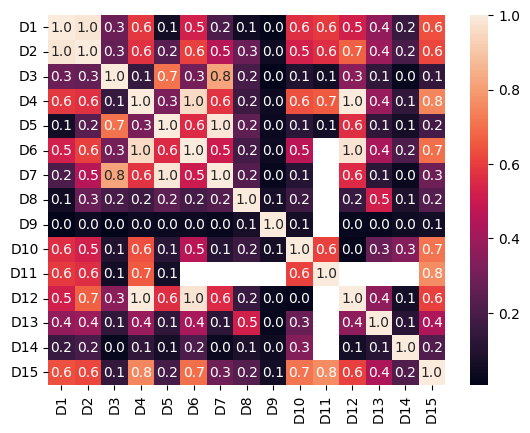

In [39]:
%matplotlib inline
sns.heatmap(corr, annot=True, fmt=".1f")
plt.show()

In [47]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


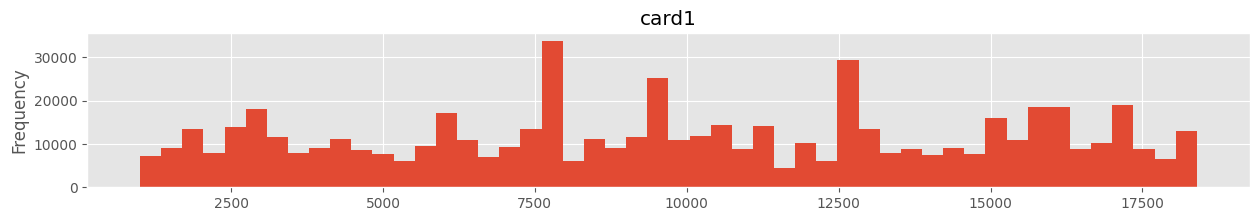

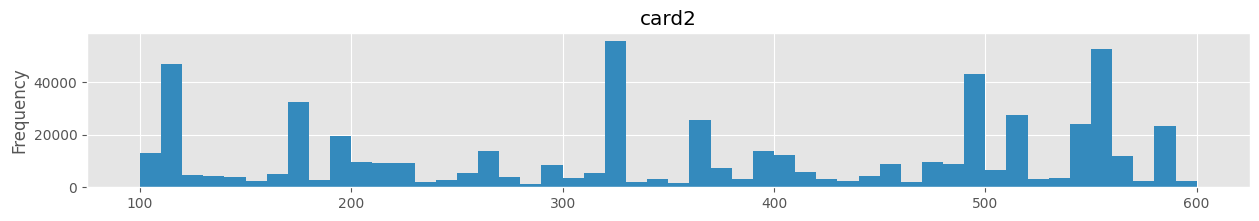

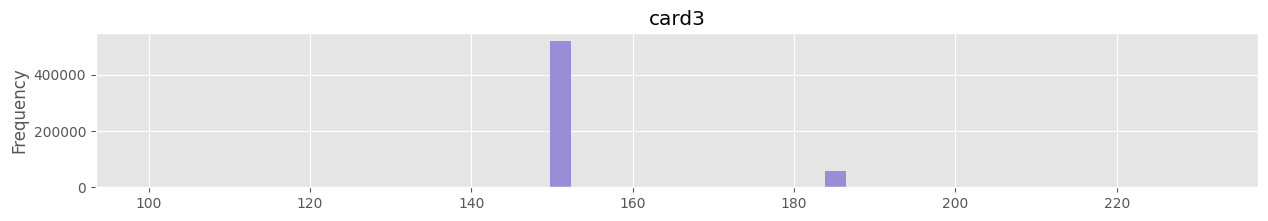

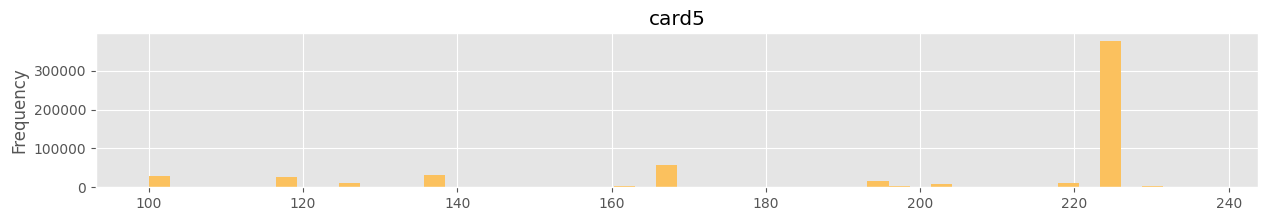

In [50]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

In [48]:
# PCA on the dataset

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x_train = train_transaction[]
y_train = train_transaction["isFraud"]

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64